In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt
from sklearn.neighbors import KNeighborsRegressor
import AISMapPlot as aismap

In [3]:
ais_learners = []
sectors = [0, 1, 2, 3, 4, 5]
sector_borders = [52.8, 4.8, 6.0, 7.2, 8.6, 9.81]
positions = pd.DataFrame([[52.8, np.nan], [np.nan, 4.8], [np.nan, 6.0], [np.nan, 7.2], [np.nan, 8.6], [np.nan, 9.81]],
                         columns = ['Latitude', 'Longitude'])
for s in sectors:
    ais_learners.append(pd.read_pickle('ROT-HAM_learners_01min_s%d.pkl' % (s)))

In [4]:
positions

,Latitude,Longitude
0,52.8,NaN
1,NaN,4.80
2,NaN,6.00
3,NaN,7.20
4,NaN,8.60
5,NaN,9.81


In [5]:
X = []
y = []
for s in sectors:
    X.append(ais_learners[s][['Latitude', 'Longitude', 'COG', 'SOG']])
    y.append(ais_learners[s][['sector_leave_lat', 'sector_leave_lon', 'mins_to_sector_leave', 'sector_leave_cog', 'sector_leave_sog']])

In [6]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

cv_splits = []
for s in sectors:
    cv_splits.append(list(GroupKFold(n_splits = 10).split(X[s], y[s], groups = ais_learners[s]['TripID'])))

In [7]:
# Retrieve ONE simple train-test split (for each sector)
train_indices = []
test_indices = []
for s in sectors:
    a, b = cv_splits[s][0]
    train_indices.append(a)
    test_indices.append(b)

X_train = []
X_test = []
for s in sectors:
    X_train.append(X[s].iloc[train_indices[s]])
    X_test.append(X[s].iloc[test_indices[s]])

y_train = []
y_test = []
for s in sectors:
    y_train.append(y[s].iloc[train_indices[s]])
    y_test.append(y[s].iloc[test_indices[s]])

In [21]:

for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 20)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-6.8575919547
-4.63718270715
-2.69708771998
-2.75776129817
-8.6427366193
-3.73688662423


In [19]:


for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 10, p=1,algorithm='kd_tree', leaf_size =100, weights= 'distance', n_jobs=-1)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-6.11640579792
-3.70624475767
-2.32438473739
-2.34097545599
-8.20615119729
-3.11674255655


In [15]:
knn_pos_list = []

for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 10, p=1,algorithm='kd_tree', leaf_size =100, weights= 'distance', n_jobs=-1)
    if s == 0:
        knn_pos.fit(X_train[s], y_train[s]['sector_leave_lon'])
    else:
        knn_pos.fit(X_train[s], y_train[s]['sector_leave_lat'])
    knn_pos_list.append(knn_pos)

In [12]:
knn_course_list = []

for s in sectors:
    knn_course = KNeighborsRegressor(n_neighbors = 10, p=1,algorithm='kd_tree', leaf_size =100, weights= 'distance', n_jobs=-1)    
    knn_course.fit(X_train[s], y_train[s]['sector_leave_cog'])
    knn_course_list.append(knn_course)

In [13]:
knn_speed_list = []

for s in sectors:
    knn_speed = KNeighborsRegressor(n_neighbors = 10, p=1,algorithm='kd_tree', leaf_size =100, weights= 'distance', n_jobs=-1)    
    knn_speed.fit(X_train[s], y_train[s]['sector_leave_sog'])
    knn_speed_list.append(knn_course)

In [24]:
#cog,sog
knn_pos_list[4].predict([[53.99, 8.17,86.0,11.0]])

array([ 53.95])

In [12]:
# 51.99 4.06, cog, sog
lats = [51.99]
lons = [4.06]
cogs =[292.0]
sogs= [15.20]
for s in sectors:
    if s == 0:
        print(sector_borders[0])
        lat = sector_borders[0]
        cog = knn_pos_list[2].predict([[lats[-1], lons[-1], cogs[-1],sogs[-1]]])[0]
        sog = knn_pos_list[3].predict([[lats[-1], lons[-1], cogs[-1],sogs[-1]]])[0]

        lon = knn_pos_list[0].predict([[lats[-1], lons[-1], cogs[-1],sogs[-1]]])[0]
    else:
        lat = knn_pos_list[s].predict([[lats[-1], lons[-1],cogs[-1],sogs[-1]]])[0]
        lon = sector_borders[s]
        cog = knn_pos_list[2].predict([[lats[-1], lons[-1], cogs[-1],sogs[-1]]])[0]
        sog = knn_pos_list[3].predict([[lats[-1], lons[-1], cogs[-1],sogs[-1]]])[0]

    lats.append(lat)
    lons.append(lon)
    cogs.append(cog)
    sogs.append(sog)
print(lats)
print(lons)
print(cogs)
print(sogs)

52.8
[51.99, 52.8, 53.431500000000007, 53.678999999999988, 53.866999999999997, 53.95000000000001, 53.54999999999999]
[4.06, 4.1875, 4.8, 6.0, 7.2, 8.6, 9.81]
[292.0, 53.679999999999993, 53.678999999999988, 53.678999999999988, 53.678999999999988, 53.678999999999988, 53.678999999999988]
[15.2, 53.86999999999999, 53.866999999999997, 53.866999999999997, 53.866999999999997, 53.866999999999997, 53.866999999999997]


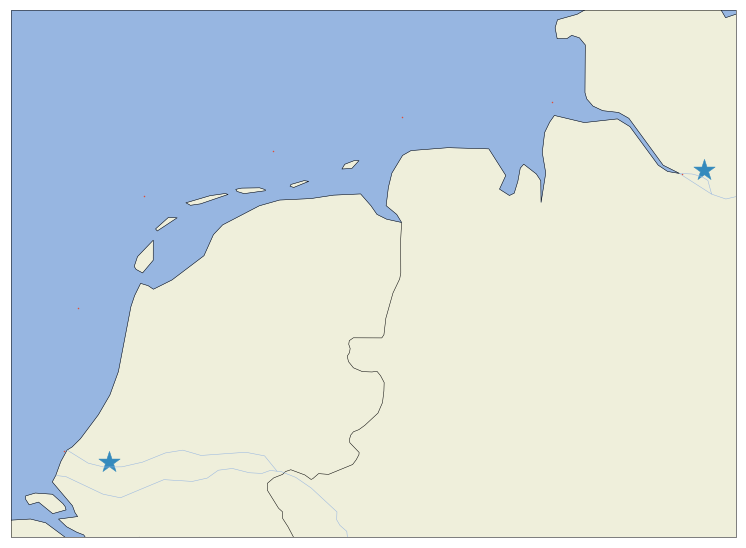

In [13]:
aismap.plot_to_map(size = (13, 13), longitude = pd.Series(lons), latitude = pd.Series(lats))

In [14]:
#current best for time
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, p=1,algorithm='kd_tree', leaf_size =100, weights= 'distance', n_jobs=-1)
    scores = cross_val_score(knn_time, X[s], y[s]['mins_to_sector_leave'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -23.883889
1 -> -10.586396
2 -> -9.272385
3 -> -9.202995
4 -> -37.540664
5 -> -13.254482


In [15]:
#test for time 
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, p =2, algorithm='kd_tree', leaf_size =100, weights= 'distance')
    scores = cross_val_score(knn_time, X[s], y[s]['mins_to_sector_leave'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -24.752406
1 -> -11.880486
2 -> -9.702952
3 -> -9.211570
4 -> -37.861319
5 -> -14.231698


In [29]:
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, p=1,algorithm='kd_tree', leaf_size =100, weights= 'distance', n_jobs=-1)
    scores = cross_val_score(knn_time, X[s], y[s]['sector_leave_lat'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -0.000000
1 -> -0.022834
2 -> -0.011620
3 -> -0.009410
4 -> -0.000775
5 -> -0.000074


In [43]:
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, p=1,algorithm='kd_tree', leaf_size =100, weights= 'distance', n_jobs=-1)
    scores = cross_val_score(knn_time, X[s], y[s]['sector_leave_cog'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -5.085145
1 -> -7.229788
2 -> -1.641299
3 -> -1.565643
4 -> -1.804844
5 -> -0.840960


In [9]:
from sklearn.ensemble import RandomForestRegressor
for s in sectors:
    rfr_time = RandomForestRegressor(n_estimators= 5, criterion= 'mae', n_jobs= -1)
    scores = cross_val_score(rfr_time, X[s], y[s]['mins_to_sector_leave'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))


KeyboardInterrupt: 

In [16]:
knn_time_list = []
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, p=1,algorithm='kd_tree', leaf_size =100, weights= 'distance', n_jobs=-1)
    knn_time.fit(X_train[s], y_train[s]['mins_to_sector_leave'])
    knn_time_list.append(knn_time)

In [45]:
#cog, sog
knn_time_list[4].predict([[53.99, 8.17,85.0,11.60]])[0]

71.0

In [ ]:
# Pickle KNN models
import pickle

for s in sectors:
    pos_model = knn_pos_list[s]
    pickle.dump(pos_model, open('../App/Agents/rot_ham_s%d/model_position.pkl' % (s), 'wb'))
    
    time_model = knn_time_list[s]
    pickle.dump(time_model, open('../App/Agents/rot_ham_s%d/model_time.pkl' % (s), 'wb'))
    
    course_model = knn_course_list[s]
    pickle.dump(course_model, open('../App/Agents/rot_ham_s%d/model_cog.pkl' % (s), 'wb'))
    
    speed_model = knn_speed_list[s]
    pickle.dump(speed_model, open('../App/Agents/rot_ham_s%d/model_sog.pkl' % (s), 'wb'))

In [47]:
test_loaded = pickle.load(open('../App/Agents/rot_ham_s%d/model_time.pkl' % (4), 'rb'))
test_loaded.predict([[53.99, 8.17,85.0,11.60]])[0]

71.0

In [48]:
print(knn_time_list[4])
print(test_loaded)

KNeighborsRegressor(algorithm='kd_tree', leaf_size=100, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=10, p=1,
          weights='distance')
KNeighborsRegressor(algorithm='kd_tree', leaf_size=100, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=10, p=1,
          weights='distance')
